In [1]:
# ------------------------------------------------------------
# 2023-03-18
# https://gradient.paperspace.com/
# Machine: Paid-RTX4000 (GPU) | 30 GiB RAM | 8 CPU | 8 GiB GPU
# ------------------------------------------------------------

In [2]:
# Note: Please follow to the About Fastai section in the README to update the fastai accordingly

In [3]:
# fastai library for training MLP on tabular data
from fastai.tabular.all import *

# for feature generation and plotting
from cryspnet.utils import *
# for accessing some pre-defined constant
from cryspnet.config import *

import pandas as pd
import numpy as np

In [4]:
# this patch prevent the dsets field to be exported by the FillMissing transform
# would be removed in the future
@patch
def setups(self:FillMissing, dsets):
    missing = pd.isnull(dsets.conts).any()
    store_attr(but='dsets', na_dict={n:self.fill_strategy(dsets[n], self.fill_vals[n]) for n in missing[missing].keys()})
    self.fill_strategy = self.fill_strategy.__name__

In [5]:
df = pd.read_csv("./demo/demo_train.csv")

In [6]:
df.head()

,formula,Space Group,Bravais,a,b,c,alpha,beta,gamma
0,C4Hf1Ta2U1,225,cubic (F),4.615,4.615,4.615,90.0,90.0,90.0
1,Co1Sb1Ta1,216,cubic (F),5.883,5.883,5.883,90.0,90.0,90.0
2,Ge0.8Sb0.133Se0.133Te0.867,225,cubic (F),5.951,5.951,5.951,90.0,90.0,90.0
3,C1Ni1,225,cubic (F),4.077,4.077,4.077,90.0,90.0,90.0
4,Ir7Mg44,216,cubic (F),20.097,20.097,20.097,90.0,90.0,90.0


# Generate features with matminer

In [7]:
fgenerator = FeatureGenerator()

In [8]:
df_predictors = fgenerator.generate(df)

StrToComposition:   0%|          | 0/280 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/280 [00:00<?, ?it/s]

In [9]:
df_predictors.head()

,formula,Space Group,Bravais,a,b,c,alpha,beta,gamma,composition,...,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr,NComp
0,C4Hf1Ta2U1,225,cubic (F),4.615,4.615,4.615,90.0,90.0,90.0,"(C, Hf, Ta, U)",...,0,0.0,0,0,0,0,0,0,0,4
1,Co1Sb1Ta1,216,cubic (F),5.883,5.883,5.883,90.0,90.0,90.0,"(Co, Sb, Ta)",...,0,0.0,0,0,0,0,0,0,0,3
2,Ge0.8Sb0.133Se0.133Te0.867,225,cubic (F),5.951,5.951,5.951,90.0,90.0,90.0,"(Ge, Sb, Se, Te)",...,0,0.0,0,0,0,0,0,0,0,4
3,C1Ni1,225,cubic (F),4.077,4.077,4.077,90.0,90.0,90.0,"(C, Ni)",...,0,0.0,0,0,0,0,0,0,0,2
4,Ir7Mg44,216,cubic (F),20.097,20.097,20.097,90.0,90.0,90.0,"(Ir, Mg)",...,0,0.0,0,0,0,0,0,0,0,2


# Train models for space groups

In [10]:
groups = df_predictors.groupby("Bravais")

In [11]:
dep_var = "Space Group"
cont_names = list(df_predictors.columns[10:])
cat_names = []

In [12]:
def initializer(df, dep_var, cont_names=[], cat_names=[], classes=None, k=3, p=0.1, is_oversample=False, n_oversample=None, bs=32):

    """
        This is a wrapper function for creating a learner. It merges categoization and oversampling process
        into one piece and assign the correct metric and loss function to the fastai learner. The columns to
        be trained on are selected by the cont_names and cat_names. Providing a classes input parameter tells
        the model the order and number of classes that the dependance variable could have. 
        
        Args:
            df: dataframe for training and validating the model
            dep_var: the dependance variable, must be a column of the df
            cont_names: column names of the continuous vairable (used for selecting the column to be trained on)
                see fastai documentation for more detail
            cat_names: column names of the category vairable (used for selecting the column to be trained on)
                see fastai documentation for more detail
            classes: vocabulary of the dependance variable (would be inferred from dep_var if not provided)
            k: k of top-k accuracy
            p: portion of train validation split. train : valid = 1-p : p
            is_oversample: boolean to enable or disable oversampling
            n_oversample: the minimum number of samples of a classes that presented in the dataset 
            bs: batch_size of the dataloader, larger the bs faster the computing speed. Reduce it if process takes too much memory.
    """    
    
    # split train and validation set and do oversampling if enabled
    val_idx= np.random.choice(df.index, int(len(df)*p), replace=False)
    if is_oversample:
        df, val_idx = oversample(df, val_idx, dep_var, nsamples=n_oversample)
    
    splits = IndexSplitter(val_idx)(df.index)
    
    # categorize
    
    if classes is None:
        classes = df[dep_var].unique()
        classes.sort()
    
    df[dep_var] = pd.Categorical(df[dep_var], categories=classes)
        
    # create datasets
    trn_cols = list(cont_names) + list(cat_names) + [dep_var]
    
    to = TabularPandas(df[trn_cols], procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names=dep_var,
                   splits=splits)
    
    # turn it into dataloader
    dls = to.dataloaders(bs=bs)
    
    # use the dataset to create the corresponding tabular learner
    # config allow us to tune the actual architecture
    config = tabular_config(ps=[0.0]+[0.1]*4, bn_cont=False, bn_final=True) # add drop out layer
    
    # metrics are for evaluation
    k = min(len(classes), k)    
    metrics = [partial(topkacc, k=k), accuracy]
    
    # create learner
    learn = tabular_learner(
        dls,
        layers=[256, 256, 256, 256], # set layer dimension
        metrics=metrics,
        config=config)
    
    learn.classes = classes # add classes to learn, important

    return learn

In [13]:
# you can modify these variable inside the config.py 
learner_folder = Path(LEARNER)
learner_folder.mkdir(exist_ok=True)

space_group_folder = learner_folder / SPACE_GROUP_MODELS_FOLDER
space_group_folder.mkdir(exist_ok=True)

Training a model on cubic (F) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.889160,1.468430,1.000000,0.000000,00:00
1,0.791522,1.540562,1.000000,0.500000,00:00
2,0.600540,2.483284,1.000000,0.000000,00:00
3,0.602775,1.558155,1.000000,0.000000,00:00
4,0.581554,1.084409,1.000000,0.500000,00:00
5,0.549016,1.201632,1.000000,0.000000,00:00
6,0.541122,1.043908,1.000000,0.500000,00:00
7,0.506398,1.131883,1.000000,0.500000,00:00
8,0.478943,1.075248,1.000000,0.500000,00:00
9,0.419490,1.112569,1.000000,0.500000,00:00


Training a model on cubic (I) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,1.041556,614938.562500,1.000000,0.000000,00:00
1,0.838716,191174.828125,1.000000,0.500000,00:00
2,0.864389,147705.937500,1.000000,0.500000,00:00
3,0.830198,38135.726562,1.000000,0.000000,00:00
4,0.697974,30254.015625,1.000000,0.500000,00:00
5,0.711247,0.000000,1.000000,1.000000,00:00
6,0.688354,41770.281250,1.000000,0.500000,00:00
7,0.670460,15375.273438,1.000000,0.500000,00:00
8,0.621732,16800.300781,1.000000,0.000000,00:00
9,0.608480,15781.506836,1.000000,0.500000,00:00


Training a model on cubic (P) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,1.094349,5141649.500000,1.000000,0.000000,00:00
1,0.958834,579968.437500,1.000000,0.000000,00:00
2,0.864792,533735.875000,1.000000,0.000000,00:00
3,0.767679,0.000000,1.000000,1.000000,00:00
4,0.790803,120388.625000,1.000000,0.500000,00:00
5,0.705029,685374.750000,1.000000,0.000000,00:00
6,0.637978,910777.687500,1.000000,0.000000,00:00
7,0.565322,583175.687500,1.000000,0.000000,00:00
8,0.588822,1934183.500000,1.000000,0.000000,00:00
9,0.540235,1017165.062500,1.000000,0.000000,00:00


Training a model on hexagonal (P) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.925924,26615.101562,1.000000,0.500000,00:00
1,0.833417,19608.699219,1.000000,0.500000,00:00
2,0.728613,59162.843750,1.000000,0.000000,00:00
3,0.703345,99595.687500,1.000000,0.000000,00:00
4,0.635409,0.000000,1.000000,1.000000,00:00
5,0.635808,40538.484375,1.000000,0.500000,00:00
6,0.592884,0.000000,1.000000,1.000000,00:00
7,0.546063,0.000000,1.000000,1.000000,00:00
8,0.550383,0.000000,1.000000,1.000000,00:00
9,0.509528,0.000000,1.000000,1.000000,00:00


Training a model on monoclinic (C) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.390300,203840.562500,1.000000,0.000000,00:00
1,0.415366,78630.507812,1.000000,0.000000,00:00
2,0.410851,10974.291016,1.000000,0.000000,00:00
3,0.395663,36850.531250,1.000000,0.000000,00:00
4,0.294129,64084.546875,1.000000,0.000000,00:00
5,0.281610,33810.796875,1.000000,0.000000,00:00
6,0.266908,39717.363281,1.000000,0.500000,00:00
7,0.276775,64456.710938,1.000000,0.000000,00:00
8,0.334645,79707.546875,1.000000,0.000000,00:00
9,0.317427,64204.164062,1.000000,0.000000,00:00


Training a model on monoclinic (P) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.000000,0.000000,1.000000,1.000000,00:00
1,0.000000,0.000000,1.000000,1.000000,00:00
2,0.000000,0.000000,1.000000,1.000000,00:00
3,0.000000,0.000000,1.000000,1.000000,00:00
4,0.000000,0.000000,1.000000,1.000000,00:00
5,0.000000,0.000000,1.000000,1.000000,00:00
6,0.000000,0.000000,1.000000,1.000000,00:00
7,0.000000,0.000000,1.000000,1.000000,00:00
8,0.000000,0.000000,1.000000,1.000000,00:00
9,0.000000,0.000000,1.000000,1.000000,00:00


Training a model on orthorhombic (C) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.841796,0.294441,1.000000,1.000000,00:00
1,0.893104,107055.742188,1.000000,0.000000,00:00
2,0.785216,46573.464844,1.000000,0.500000,00:00
3,0.625526,19306.619141,1.000000,0.500000,00:00
4,0.624159,25465.023438,1.000000,0.500000,00:00
5,0.630752,8218.118164,1.000000,0.500000,00:00
6,0.570965,22948.853516,1.000000,0.500000,00:00
7,0.461754,16586.453125,1.000000,0.500000,00:00
8,0.443119,15803.442383,1.000000,0.500000,00:00
9,0.392885,14019.881836,1.000000,0.500000,00:00


Training a model on orthorhombic (F) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.851993,263291.156250,1.000000,0.500000,00:00
1,0.807950,13847.932617,1.000000,0.500000,00:00
2,0.664815,63754.898438,1.000000,0.500000,00:00
3,0.587221,84793.375000,1.000000,0.500000,00:00
4,0.616347,51556.492188,1.000000,0.000000,00:00
5,0.585368,75940.773438,1.000000,0.500000,00:00
6,0.578356,45534.496094,1.000000,0.500000,00:00
7,0.572276,16779.507812,1.000000,0.500000,00:00
8,0.524431,19090.896484,1.000000,0.500000,00:00
9,0.495357,47336.324219,1.000000,0.500000,00:00


Training a model on orthorhombic (I) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,1.079201,82019.531250,1.000000,0.500000,00:00
1,0.887569,0.000000,1.000000,1.000000,00:00
2,0.842656,6841.677734,1.000000,0.500000,00:00
3,0.716856,22374.406250,1.000000,0.500000,00:00
4,0.571427,38659.425781,1.000000,0.500000,00:00
5,0.551990,41173.304688,1.000000,0.500000,00:00
6,0.563209,37095.445312,1.000000,0.500000,00:00
7,0.506923,22491.328125,1.000000,0.500000,00:00
8,0.478073,25937.210938,1.000000,0.500000,00:00
9,0.484753,19479.542969,1.000000,0.500000,00:00


Training a model on orthorhombic (P) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.735173,0.000000,1.000000,1.000000,00:00
1,0.674260,0.000000,1.000000,1.000000,00:00
2,0.650308,27037.117188,1.000000,0.000000,00:00
3,0.608314,8853.593750,1.000000,0.000000,00:00
4,0.595615,76198.140625,1.000000,0.000000,00:00
5,0.630810,131017.906250,1.000000,0.000000,00:00
6,0.541053,0.000000,1.000000,1.000000,00:00
7,0.519748,0.000000,1.000000,1.000000,00:00
8,0.511637,0.000000,1.000000,1.000000,00:00
9,0.497057,545.390625,1.000000,0.000000,00:00


Training a model on rhombohedral (P) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,1.015402,12308.201172,1.000000,0.500000,00:00
1,0.946669,12096.833984,1.000000,0.500000,00:00
2,0.872667,5771.736328,1.000000,0.500000,00:00
3,0.757196,9937.908203,1.000000,0.500000,00:00
4,0.711943,725.927979,1.000000,0.500000,00:00
5,0.773190,1913.396729,1.000000,0.500000,00:00
6,0.661526,1048.049927,1.000000,0.500000,00:00
7,0.638726,4444.925293,1.000000,0.500000,00:00
8,0.589577,4717.274902,1.000000,0.500000,00:00
9,0.563648,4369.652344,1.000000,0.500000,00:00


Training a model on tetragonal (I) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.606126,0.000000,1.000000,1.000000,00:00
1,0.491792,996.839539,1.000000,0.500000,00:00
2,0.447728,1610.567627,1.000000,0.500000,00:00
3,0.424395,0.000000,1.000000,1.000000,00:00
4,0.377935,1150.713135,1.000000,0.500000,00:00
5,0.335518,782.093872,1.000000,0.500000,00:00
6,0.324392,1662.798828,1.000000,0.500000,00:00
7,0.264157,1998.502686,1.000000,0.500000,00:00
8,0.275455,1432.236328,1.000000,0.500000,00:00
9,0.273542,1161.044800,1.000000,0.500000,00:00


Training a model on tetragonal (P) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.873791,5780388.000000,1.000000,0.000000,00:00
1,0.818789,7596963.000000,1.000000,0.000000,00:00
2,0.772353,6416440.000000,1.000000,0.000000,00:00
3,0.762030,6637704.000000,1.000000,0.000000,00:00
4,0.714393,7665534.000000,1.000000,0.000000,00:00
5,0.620255,6016543.000000,1.000000,0.000000,00:00
6,0.597730,7584039.000000,1.000000,0.000000,00:00
7,0.563376,7032546.000000,1.000000,0.000000,00:00
8,0.602855,8380920.000000,1.000000,0.000000,00:00
9,0.615509,10093832.000000,1.000000,0.000000,00:00


Training a model on triclinic (P) subset


/notebooks/venv/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,0.000000,0.000000,1.000000,1.000000,00:00
1,0.000000,0.000000,1.000000,1.000000,00:00
2,0.000000,0.000000,1.000000,1.000000,00:00
3,0.000000,0.000000,1.000000,1.000000,00:00
4,0.000000,0.000000,1.000000,1.000000,00:00
5,0.000000,0.000000,1.000000,1.000000,00:00
6,0.000000,0.000000,1.000000,1.000000,00:00
7,0.000000,0.000000,1.000000,1.000000,00:00
8,0.000000,0.000000,1.000000,1.000000,00:00
9,0.000000,0.000000,1.000000,1.000000,00:00


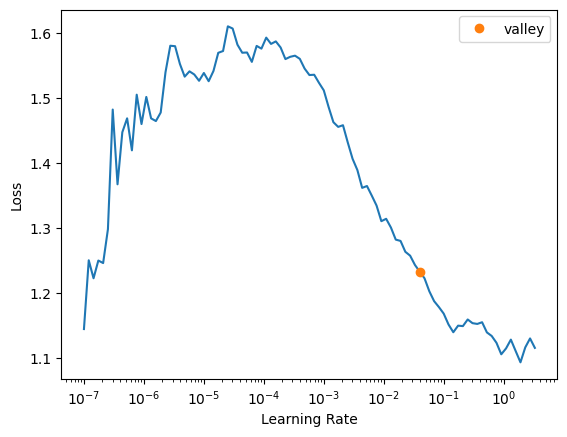

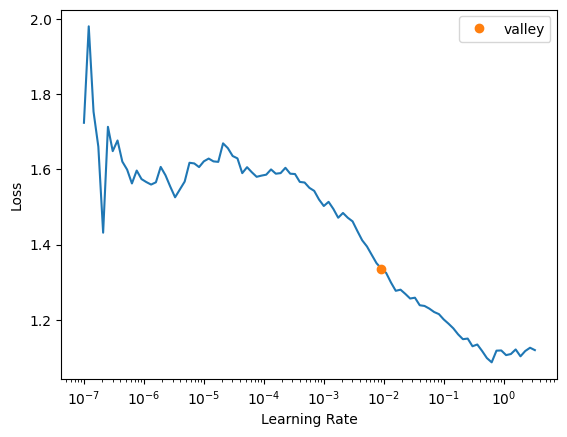

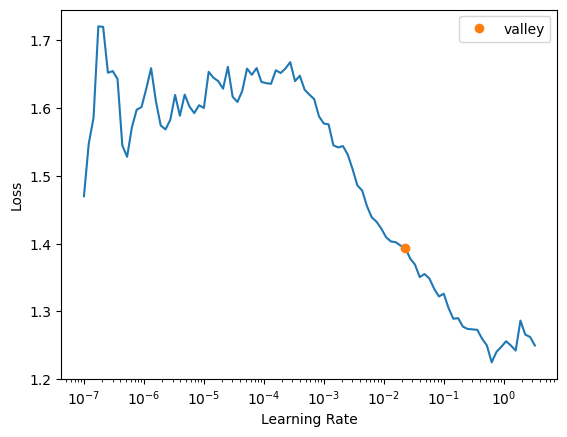

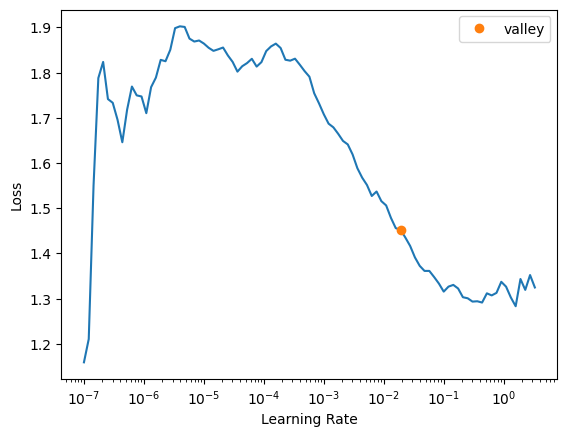

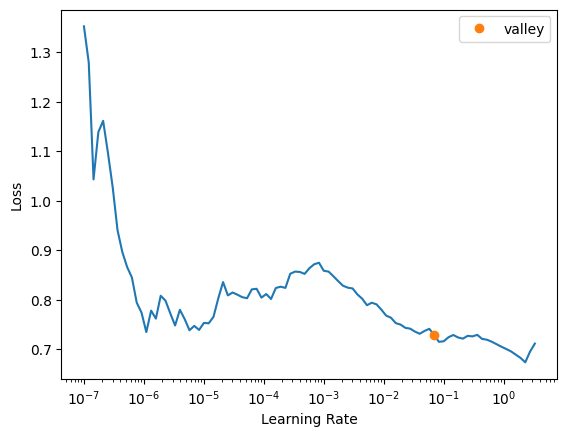

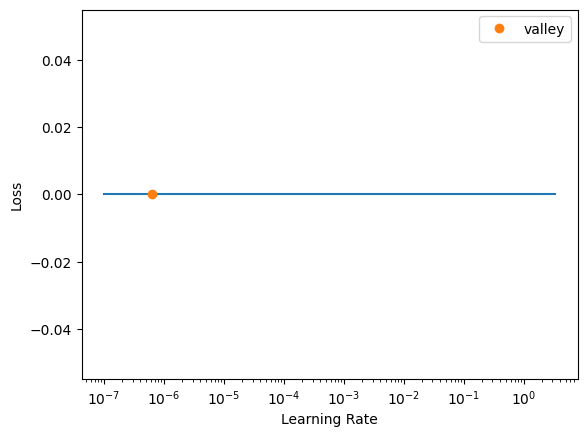

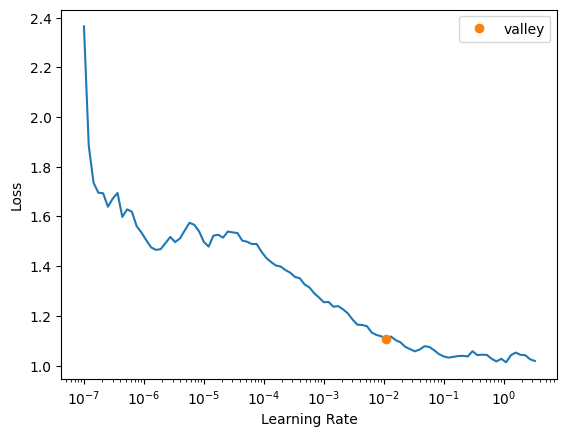

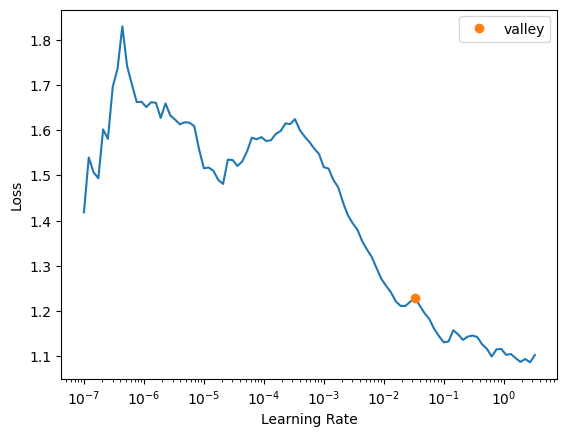

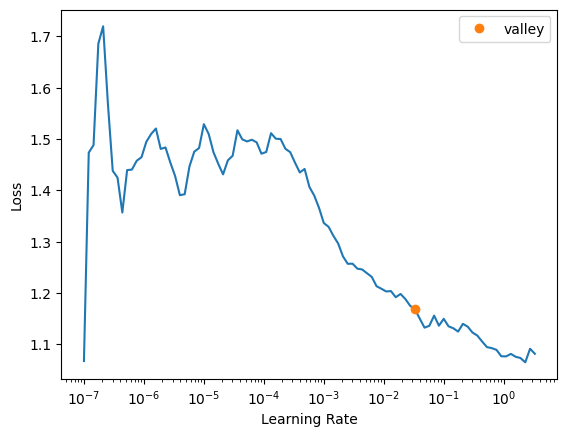

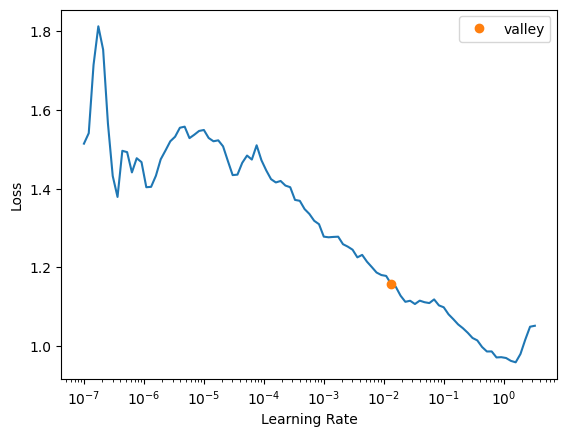

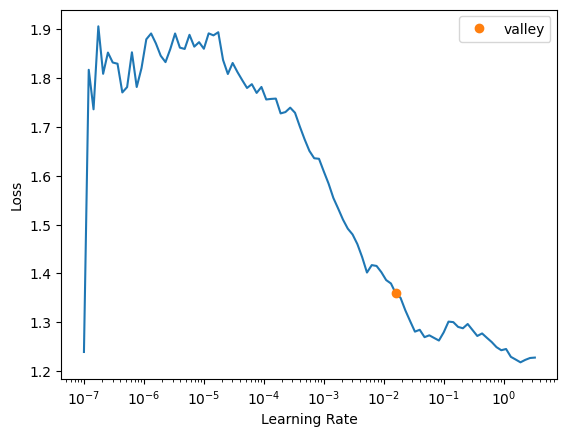

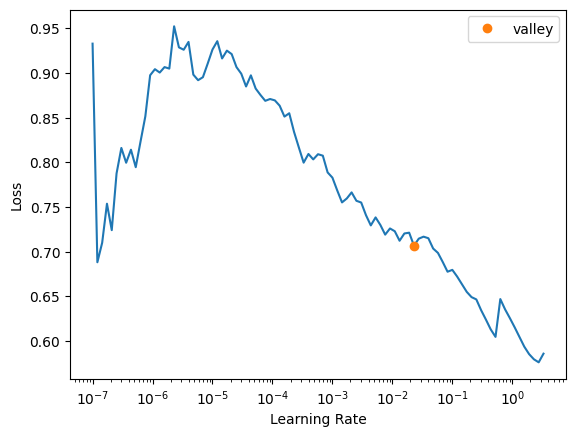

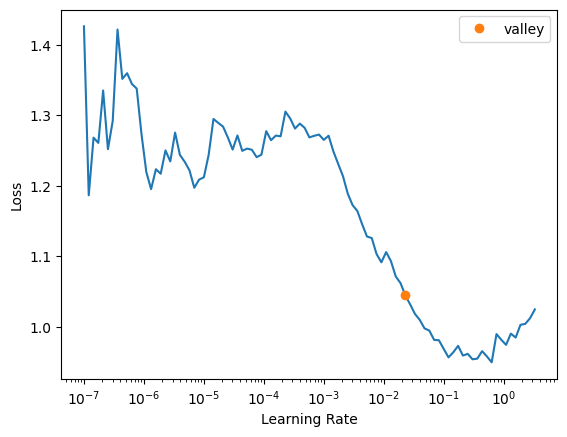

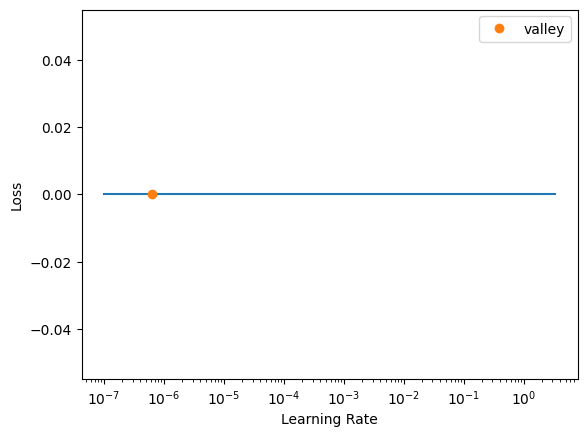

In [14]:
for Bravais, group in groups:    
    print(f"Training a model on {Bravais} subset")
    group = group.reset_index(drop=True)
    
    # remove entries with space group that only occur once in the dataset
    vc = group['Space Group'].value_counts()
    single_sg = vc.index[vc==1]
    group = group.loc[ group['Space Group'].map(lambda x: x not in single_sg) ]
    
    # create learner
    learn = initializer(
        group,
        dep_var,
        cont_names=cont_names,
        is_oversample=True,
        n_oversample=100,
        p=0.2,
        bs=4
    )
    
    # find the learning rate 
    suggestions = learn.lr_find()
    
    # you can use one of lr setting in the suggestion or define it yourself
    # lr_max = suggestions.lr_steep
    lr_max = 1e-2
    
    # training the model using one cycle policy
    learn.fit_one_cycle(10, lr_max=lr_max)
    
    # save the learner
    learn.export(space_group_folder / f"{Bravais}.pkl")
